In [1]:
rm(list = ls())

library(LalRUtils)
libreq(data.table, magrittr, tidyverse, janitor, huxtable, knitr, patchwork, timeDate, plotly)
# theme_set(lal_plot_theme(textangle = 90))
theme_set(lal_plot_theme(textangle = 90))
set.seed(42)
options(repr.plot.width = 15, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "magrittr"   TRUE  
 [3,] "tidyverse"  TRUE  
 [4,] "janitor"    TRUE  
 [5,] "huxtable"   TRUE  
 [6,] "knitr"      TRUE  
 [7,] "patchwork"  TRUE  
 [8,] "timeDate"   TRUE  
 [9,] "plotly"     TRUE  


# Mobility Reports Query
[info](https://console.cloud.google.com/marketplace/details/bigquery-public-datasets/covid19_google_mobility?filter=solution-type%3Adataset&id=db650d71-e53e-4677-b37b-d8bdca3ec4dc&project=spatial-acumen-244921&folder&organizationId)

In [2]:
libreq(tidyverse, DBI, dbplyr, RSQLite, bigrquery, tictoc)

     wants       loaded
[1,] "tidyverse" TRUE  
[2,] "DBI"       TRUE  
[3,] "dbplyr"    TRUE  
[4,] "RSQLite"   TRUE  
[5,] "bigrquery" TRUE  
[6,] "tictoc"    TRUE  


In [3]:
projid <- Sys.getenv("GCE_DEFAULT_PROJECT_ID")
bq_auth(email = "lal.apoorva@gmail.com",
       path = "~/keys/sandbox.json")

In [4]:
bq_con <-  dbConnect(
    bigrquery::bigquery(),
    project = "bigquery-public-data",
    dataset = "covid19_google_mobility",
    billing = projid
    )
bq_con
dbListTables(bq_con)

<BigQueryConnection>
  Dataset: bigquery-public-data.covid19_google_mobility
  Billing: spatial-acumen-244921

[1] "mobility_report"

In [5]:
mob <- tbl(bq_con, "mobility_report")
mob %>% glimpse

Rows: ??
Columns: 13
Database: BigQueryConnection
$ country_region_code                                <chr> "AE", "AE", "AE", …
$ country_region                                     <chr> "United Arab Emira…
$ sub_region_1                                       <chr> "Abu Dhabi", "Abu …
$ sub_region_2                                       <chr> NA, NA, NA, NA, NA…
$ iso_3166_2_code                                    <chr> "AE-AZ", "AE-AZ", …
$ census_fips_code                                   <chr> NA, NA, NA, NA, NA…
$ date                                               <date> 2020-02-15, 2020-…
$ retail_and_recreation_percent_change_from_baseline <int> 1, -2, -3, -3, -3,…
$ grocery_and_pharmacy_percent_change_from_baseline  <int> 6, 5, 2, 2, 1, 2, …
$ parks_percent_change_from_baseline                 <int> -2, 2, 4, 1, 0, 3,…
$ transit_stations_percent_change_from_baseline      <int> -1, -2, -3, -2, -1…
$ workplaces_percent_change_from_baseline            <int> 2, 2, 2, 2, 2, 1, …
$ 

In [6]:
tic()
mob %>% collect() ->
    mobility_df
toc()

48.022 sec elapsed


In [7]:
mobility_df %<>% setDT
mobility_df %>% glimpse()

Rows: 571,342
Columns: 13
$ country_region_code                                <chr> "AE", "AE", "AE", …
$ country_region                                     <chr> "United Arab Emira…
$ sub_region_1                                       <chr> "Abu Dhabi", "Abu …
$ sub_region_2                                       <chr> NA, NA, NA, NA, NA…
$ iso_3166_2_code                                    <chr> "AE-AZ", "AE-AZ", …
$ census_fips_code                                   <chr> NA, NA, NA, NA, NA…
$ date                                               <date> 2020-02-15, 2020-…
$ retail_and_recreation_percent_change_from_baseline <int> 1, -2, -3, -3, -3,…
$ grocery_and_pharmacy_percent_change_from_baseline  <int> 6, 5, 2, 2, 1, 2, …
$ parks_percent_change_from_baseline                 <int> -2, 2, 4, 1, 0, 3,…
$ transit_stations_percent_change_from_baseline      <int> -1, -2, -3, -2, -1…
$ workplaces_percent_change_from_baseline            <int> 2, 2, 2, 2, 2, 1, …
$ residential_percent_chan

In [8]:
fwrite(mobility_df, "data/google-mobility-reports.csv")
dbDisconnect(bq_con)

## Viz

In [9]:
mobility_df = fread("data/google-mobility-reports.csv")
old = c('retail_and_recreation_percent_change_from_baseline',
  'grocery_and_pharmacy_percent_change_from_baseline',
  'parks_percent_change_from_baseline',
  'transit_stations_percent_change_from_baseline',
  'workplaces_percent_change_from_baseline',
  'residential_percent_change_from_baseline')
new = c("retail", "grocery", "parks", "transit", "work", "home")
setnames(mobility_df, old, new)
mobility_df[, d := lubridate::ymd(date)]
mobility_df[, weekend := isWeekend(d)]
mobility_df %>% glimpse

Rows: 571,342
Columns: 15
$ country_region_code <chr> "AE", "AE", "AE", "AE", "AE", "AE", "AE", "AE", "…
$ country_region      <chr> "United Arab Emirates", "United Arab Emirates", "…
$ sub_region_1        <chr> "Abu Dhabi", "Abu Dhabi", "Abu Dhabi", "Abu Dhabi…
$ sub_region_2        <chr> "", "", "", "", "", "", "", "", "", "", "", "", "…
$ iso_3166_2_code     <chr> "AE-AZ", "AE-AZ", "AE-AZ", "AE-AZ", "AE-AZ", "AE-…
$ census_fips_code    <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ date                <chr> "2020-02-15", "2020-02-16", "2020-02-17", "2020-0…
$ retail              <int> 1, -2, -3, -3, -3, -2, 0, -1, -2, -3, -3, -3, 2, …
$ grocery             <int> 6, 5, 2, 2, 1, 2, 5, 4, 4, 2, 2, 2, 7, 9, 10, 12,…
$ parks               <int> -2, 2, 4, 1, 0, 3, 8, 2, 2, 6, 2, -5, -2, -3, -3,…
$ transit             <int> -1, -2, -3, -2, -1, -3, -5, -2, -3, -5, -3, -3, -…
$ work                <int> 2, 2, 2, 2, 2, 1, -1, 3, 3, 3, 2, 2, 2, 1, 4, 3, …
$ home                <int

### US Counties

In [10]:
us_mob = mobility_df[country_region_code == "US"]
us_mob %>% head

country_region_code country_region sub_region_1 sub_region_2 iso_3166_2_code
1 US                  United States  Alabama                   US-AL          
2 US                  United States  Alabama                   US-AL          
3 US                  United States  Alabama                   US-AL          
4 US                  United States  Alabama                   US-AL          
5 US                  United States  Alabama                   US-AL          
6 US                  United States  Alabama                   US-AL          
  census_fips_code date       retail grocery parks transit work home d         
1 NA               2020-02-15  5      2       39    7        2  -1   2020-02-15
2 NA               2020-02-16  0     -2       -7    3       -1   1   2020-02-16
3 NA               2020-02-17  3      0       17    7      -17   4   2020-02-17
4 NA               2020-02-18 -4     -3      -11   -1        1   2   2020-02-18
5 NA               2020-02-19  4      1        6    4        1   0   2020-02-19
6 NA               2020-02-20 -7     -6      -25   -1        0   3   2020-02-20
  weekend
1  TRUE  
2  TRUE  
3 FALSE  
4 FALSE  
5 FALSE  
6 FALSE

In [11]:
bay   = paste0(c( "San Francisco", "San Mateo", "Santa Clara",
                        "Alameda", "Contra Costa", "Marin"), " County")

socal = paste0(c("Los Angeles", "Orange", "San Bernardino", "Riverside", "Ventura", "Merced"),
               " County")

bay_area = us_mob[sub_region_1 == "California" & sub_region_2 %in% bay ]

la_area = us_mob[sub_region_1 == "California" & sub_region_2 %in% socal ]

# long
bay_area2 = melt(bay_area, id.vars = c("sub_region_2", "d", "weekend"),
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")
la_area2 = melt(la_area, id.vars = c("sub_region_2", "d", "weekend"),
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")

bay_area2 %>% head

sub_region_2   d          weekend category value
1 Alameda County 2020-02-15  TRUE   retail    1   
2 Alameda County 2020-02-16  TRUE   retail    7   
3 Alameda County 2020-02-17 FALSE   retail   13   
4 Alameda County 2020-02-18 FALSE   retail   -2   
5 Alameda County 2020-02-19 FALSE   retail   -1   
6 Alameda County 2020-02-20 FALSE   retail    1

Function to plot mobility with sensible faceting + gray bars for weekends.

In [12]:
mobility_faceted = function(df, cmap = T, leg = T, wknd = T){
    p =  ggplot(df, aes(x = d, y = value, group = category, colour = category))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p + geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.8) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            scale_x_date(date_breaks = "1 week", date_labels = "%b %d") +
            facet_wrap(~ sub_region_2, scale = "free")
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}


mobility_plotter = function(df, col, cmap = T, leg = F){
    p = df %>%
        ggplot(aes(x = d, y = {{ col }}, group = sub_region_2, colour = sub_region_2)) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1) +
            geom_point() + geom_smooth(se = F) +
            scale_x_date(date_breaks = "1 week", date_labels = "%b %d")
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



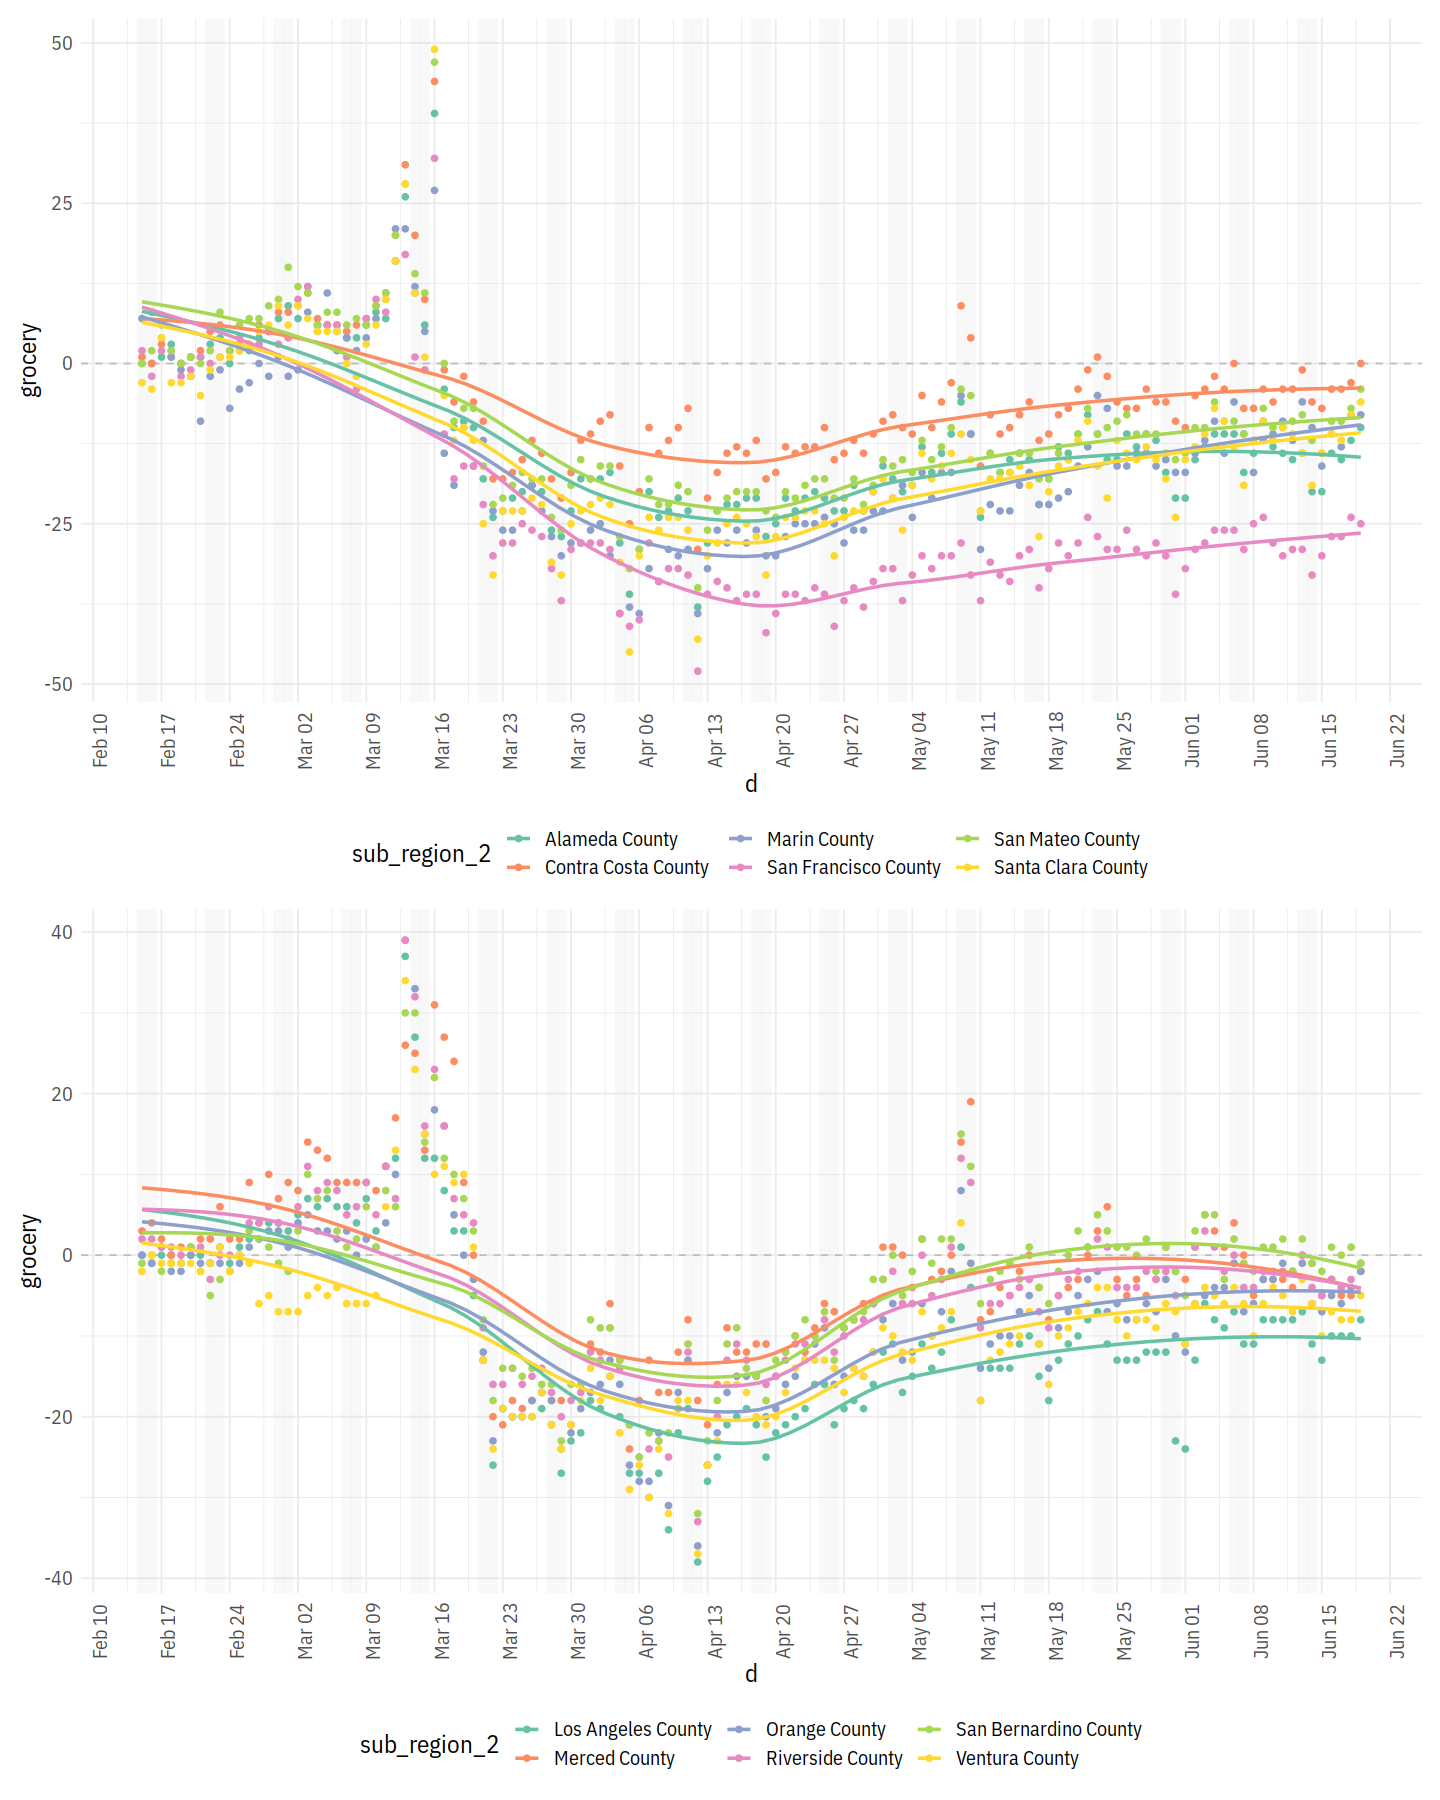

In [13]:
options(repr.plot.width = 12, repr.plot.height=15)
mobility_plotter(bay_area, grocery, leg = T) / mobility_plotter(la_area, grocery, leg = T)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



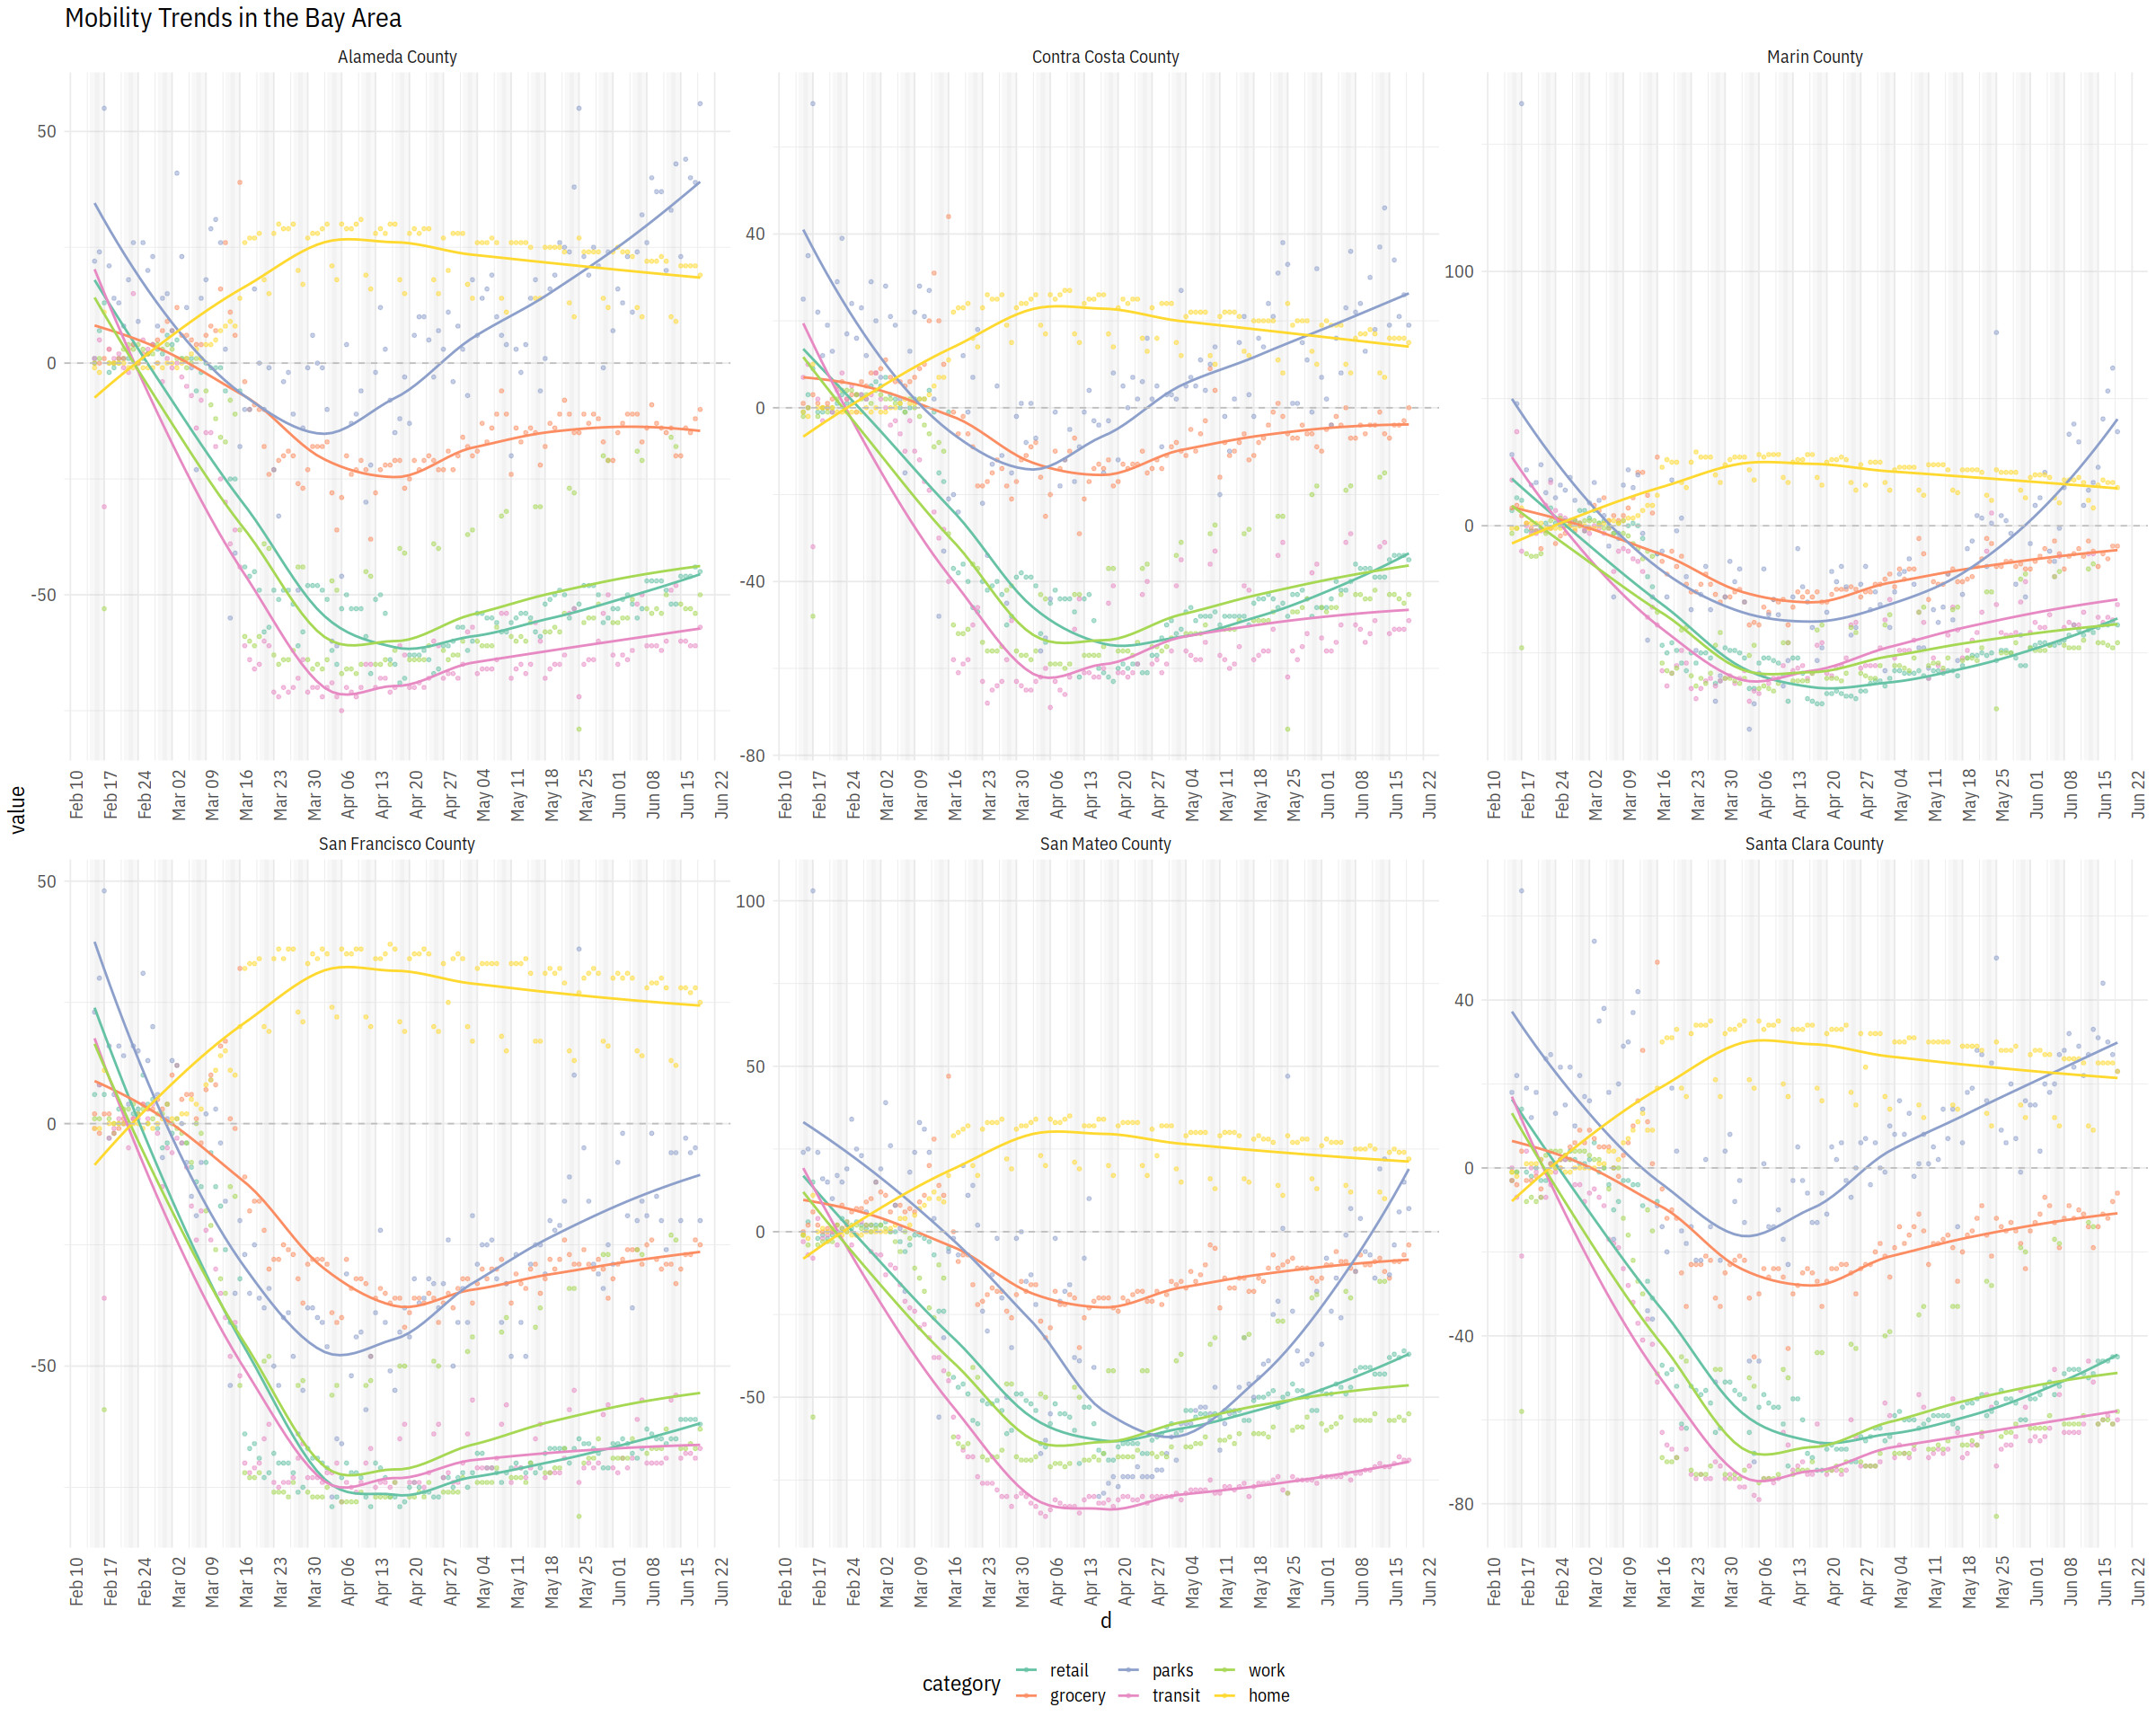

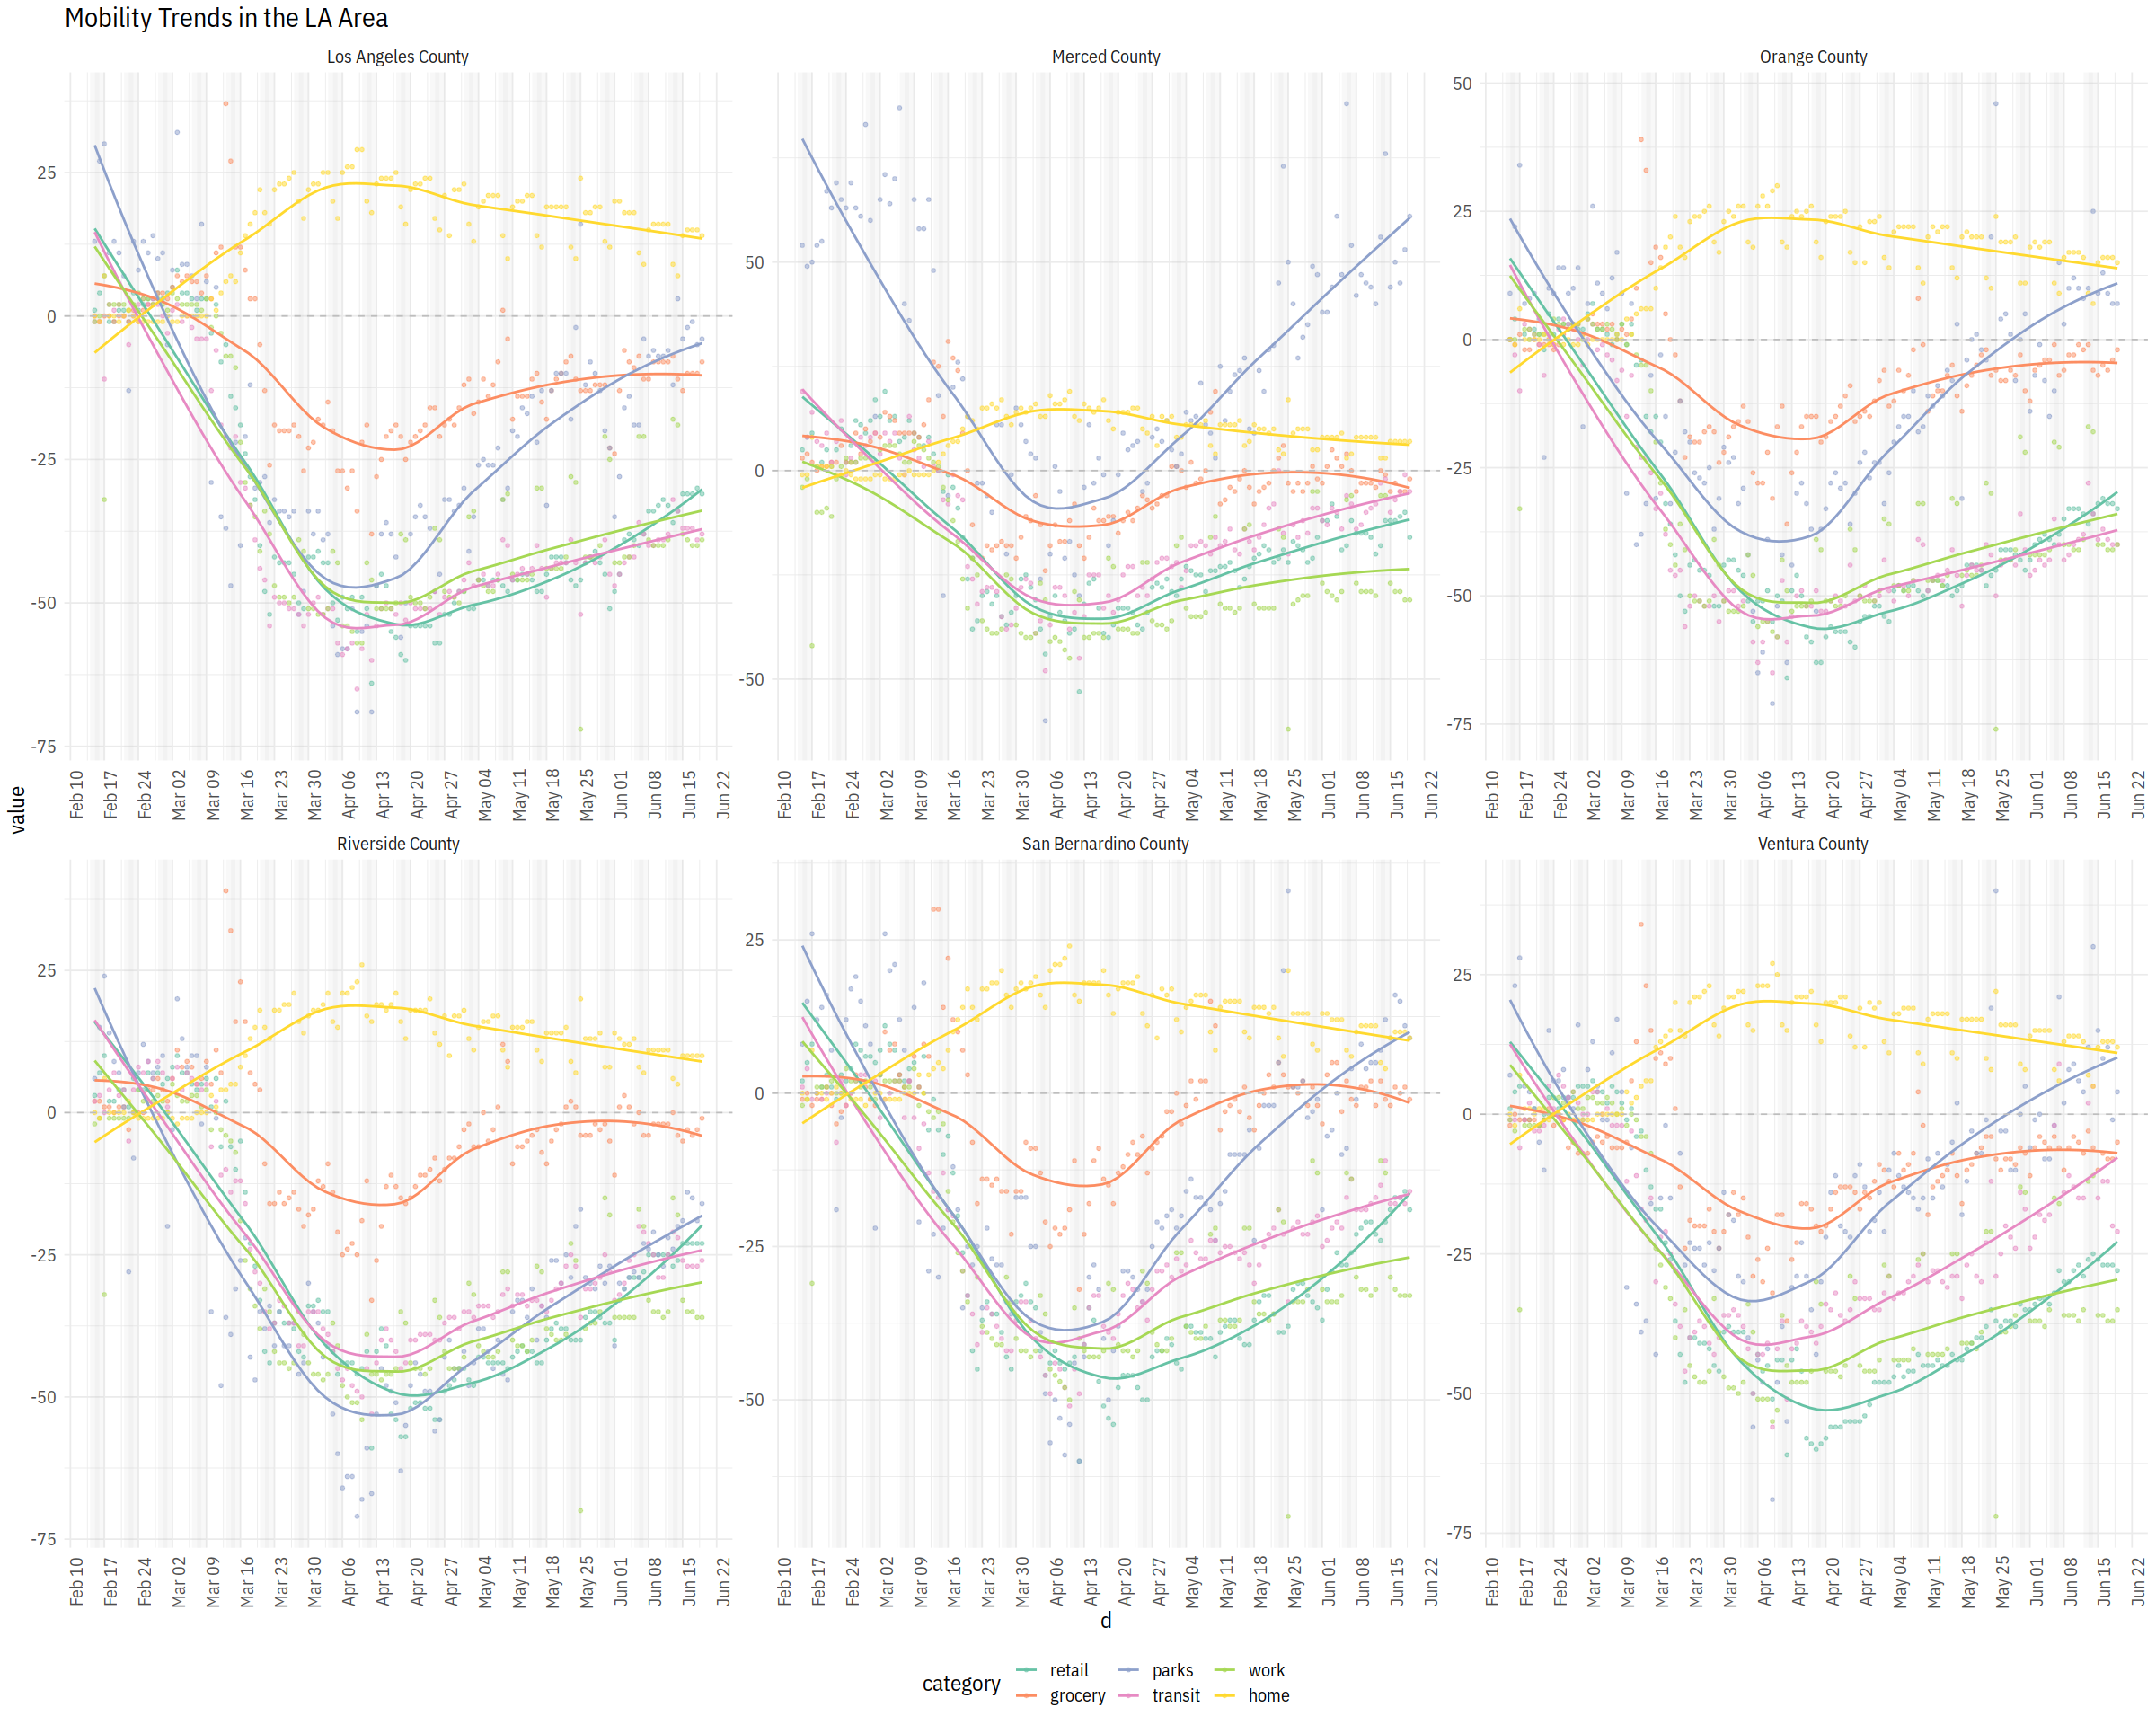

In [14]:
options(repr.plot.width = 20, repr.plot.height=16)
mobility_faceted(bay_area2) + ggtitle("Mobility Trends in the Bay Area")
mobility_faceted(la_area2)  + ggtitle("Mobility Trends in the LA Area")

## International

In [15]:
melter = function(df, keys = c("country_region", "d", "weekend")){
    df_long = melt(df, id.vars = keys,
        measure = c("retail", "grocery", "parks", "transit", "work", "home"),
        variable.name = "category")
    return(df_long)
}

subregion_faceted = function(df, cmap = T, freescale = F, leg = T, wknd = T){
    p = ggplot(df, aes(x = d, y = value, group = category, colour = category))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T], mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p +
        geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.6) +
        geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (freescale == T) {
        p = p + facet_wrap(~ sub_region_1, scale = "free_y")
    } else{
        p = p + facet_wrap(~ sub_region_1)
    }
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

country_faceted = function(df, freescale = F,  cmap = F, leg = F, wknd = T){
    p = ggplot(df, aes(x = d, y = value))
    if (wknd == T){
        p = p + geom_vline(data = df[weekend == T], mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.1)
    }
    p = p +
        geom_point(size = 1, alpha = 0.5) + geom_smooth(se = F, size = 0.6) +
        geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (freescale == T) {
        p = p + facet_wrap(~ category, scale = "free")
    } else{
        p = p + facet_wrap(~ category)
    }
    if (cmap == T) p = p + scale_colour_brewer(palette = "Set2")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

mob_plotter = function(df, col, grp, leg = T){
    p = df %>%
        ggplot(aes(x = d, y = {{ col }}, group = {{grp}}, colour = {{grp}})) +
            geom_hline(yintercept = 0, colour = 'gray', linetype = 'dashed') +
            geom_vline(data = df[weekend == T],
                     mapping = aes(xintercept = d),
                     color = 'gray', size = 2.9, alpha = 0.3) +
        geom_point() + geom_smooth(se = F) +
        scale_x_date(date_breaks = "1 week", date_labels = "%m-%d")
    if (leg == F) p = p + guides(colour = F)
    return(p)
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



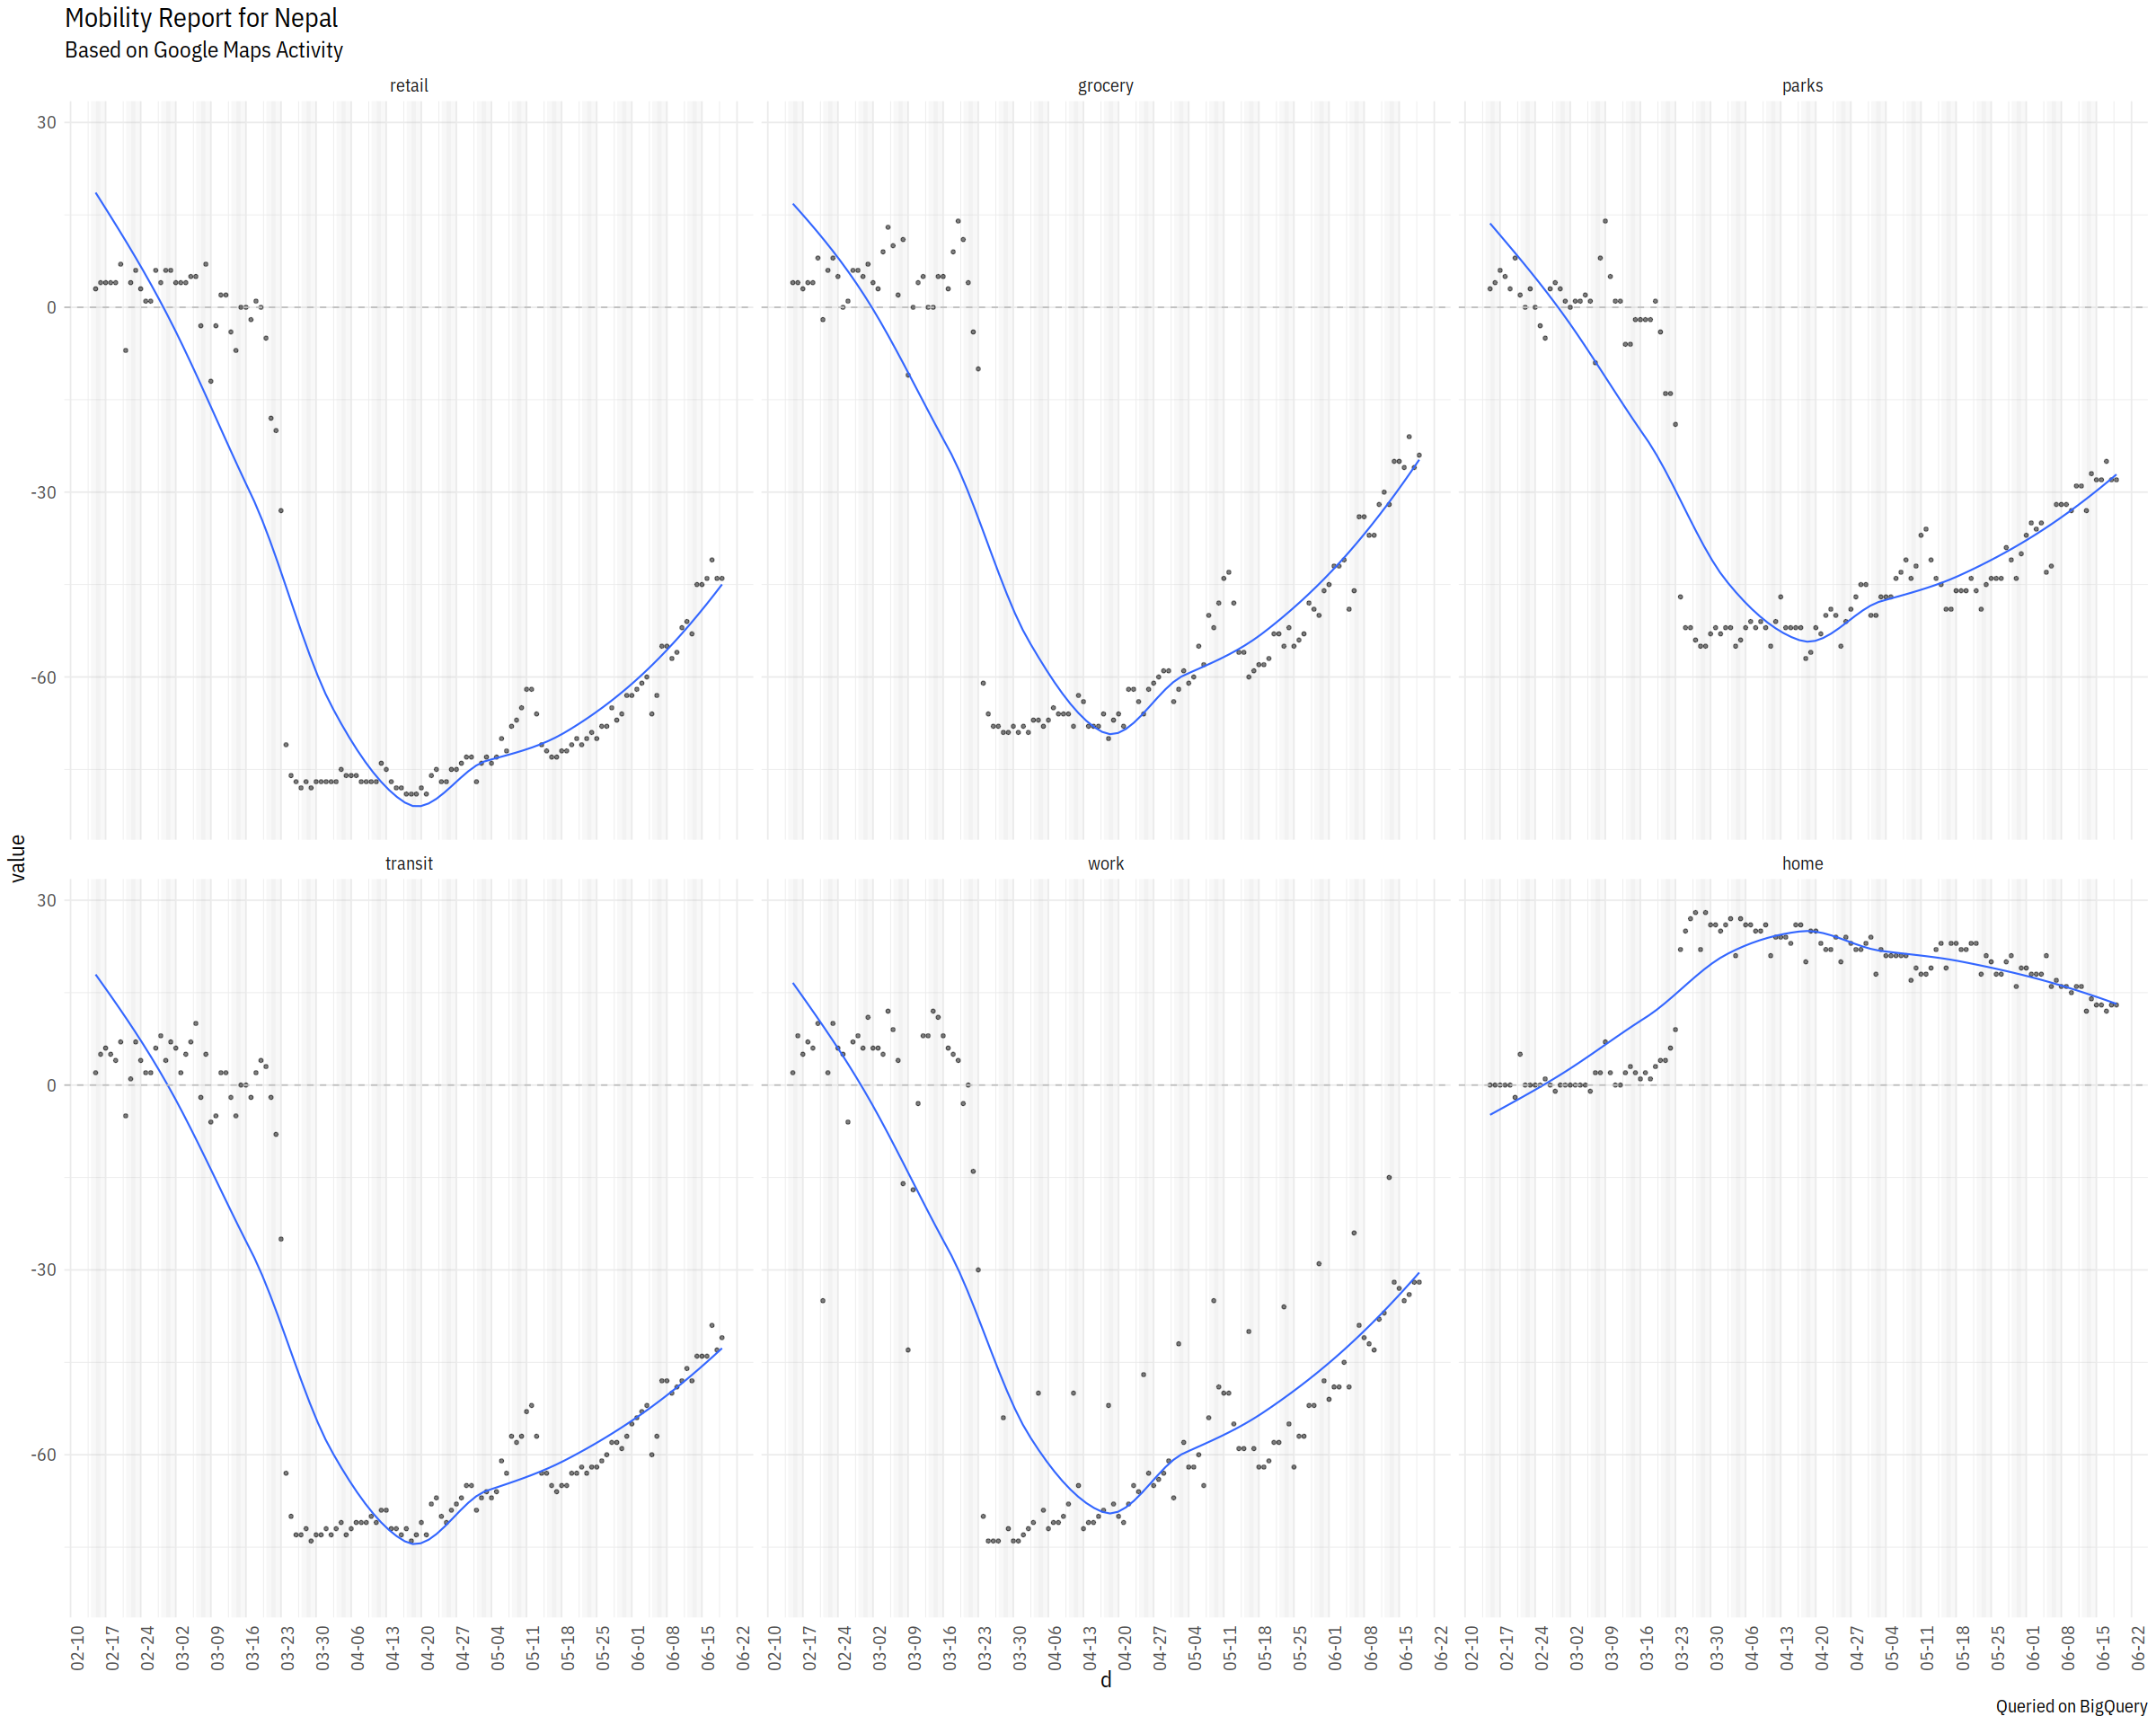

In [16]:
nep = mobility_df[country_region =="Nepal"]
nep_l = melter(nep)
(nep = country_faceted(nep_l) +
    labs(title = "Mobility Report for Nepal", subtitle = "Based on Google Maps Activity", caption = "Queried on BigQuery"))

In [18]:
ggsave("nep_mobility.jpg", nep, width = 20, height = 15)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



country_region_code country_region sub_region_1                sub_region_2
1 IN                  India          Andaman and Nicobar Islands             
2 IN                  India          Andaman and Nicobar Islands             
3 IN                  India          Andaman and Nicobar Islands             
4 IN                  India          Andaman and Nicobar Islands             
5 IN                  India          Andaman and Nicobar Islands             
6 IN                  India          Andaman and Nicobar Islands             
  iso_3166_2_code census_fips_code date       retail grocery parks transit work
1 IN-AN           NA               2020-02-15  1     -9       5    -2      6   
2 IN-AN           NA               2020-02-16  0     -6       1     2      4   
3 IN-AN           NA               2020-02-17 -1      2       5     1      6   
4 IN-AN           NA               2020-02-18 -2     12      -4    -1      4   
5 IN-AN           NA               2020-02-19 -5      9      -6     2      4   
6 IN-AN           NA               2020-02-20 -2     -4       3    -1      1   
  home d          weekend
1  2   2020-02-15  TRUE  
2 NA   2020-02-16  TRUE  
3  1   2020-02-17 FALSE  
4  3   2020-02-18 FALSE  
5  1   2020-02-19 FALSE  
6  1   2020-02-20 FALSE

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 691 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 691 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 691 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 691 rows containing missing values (geom_point).”


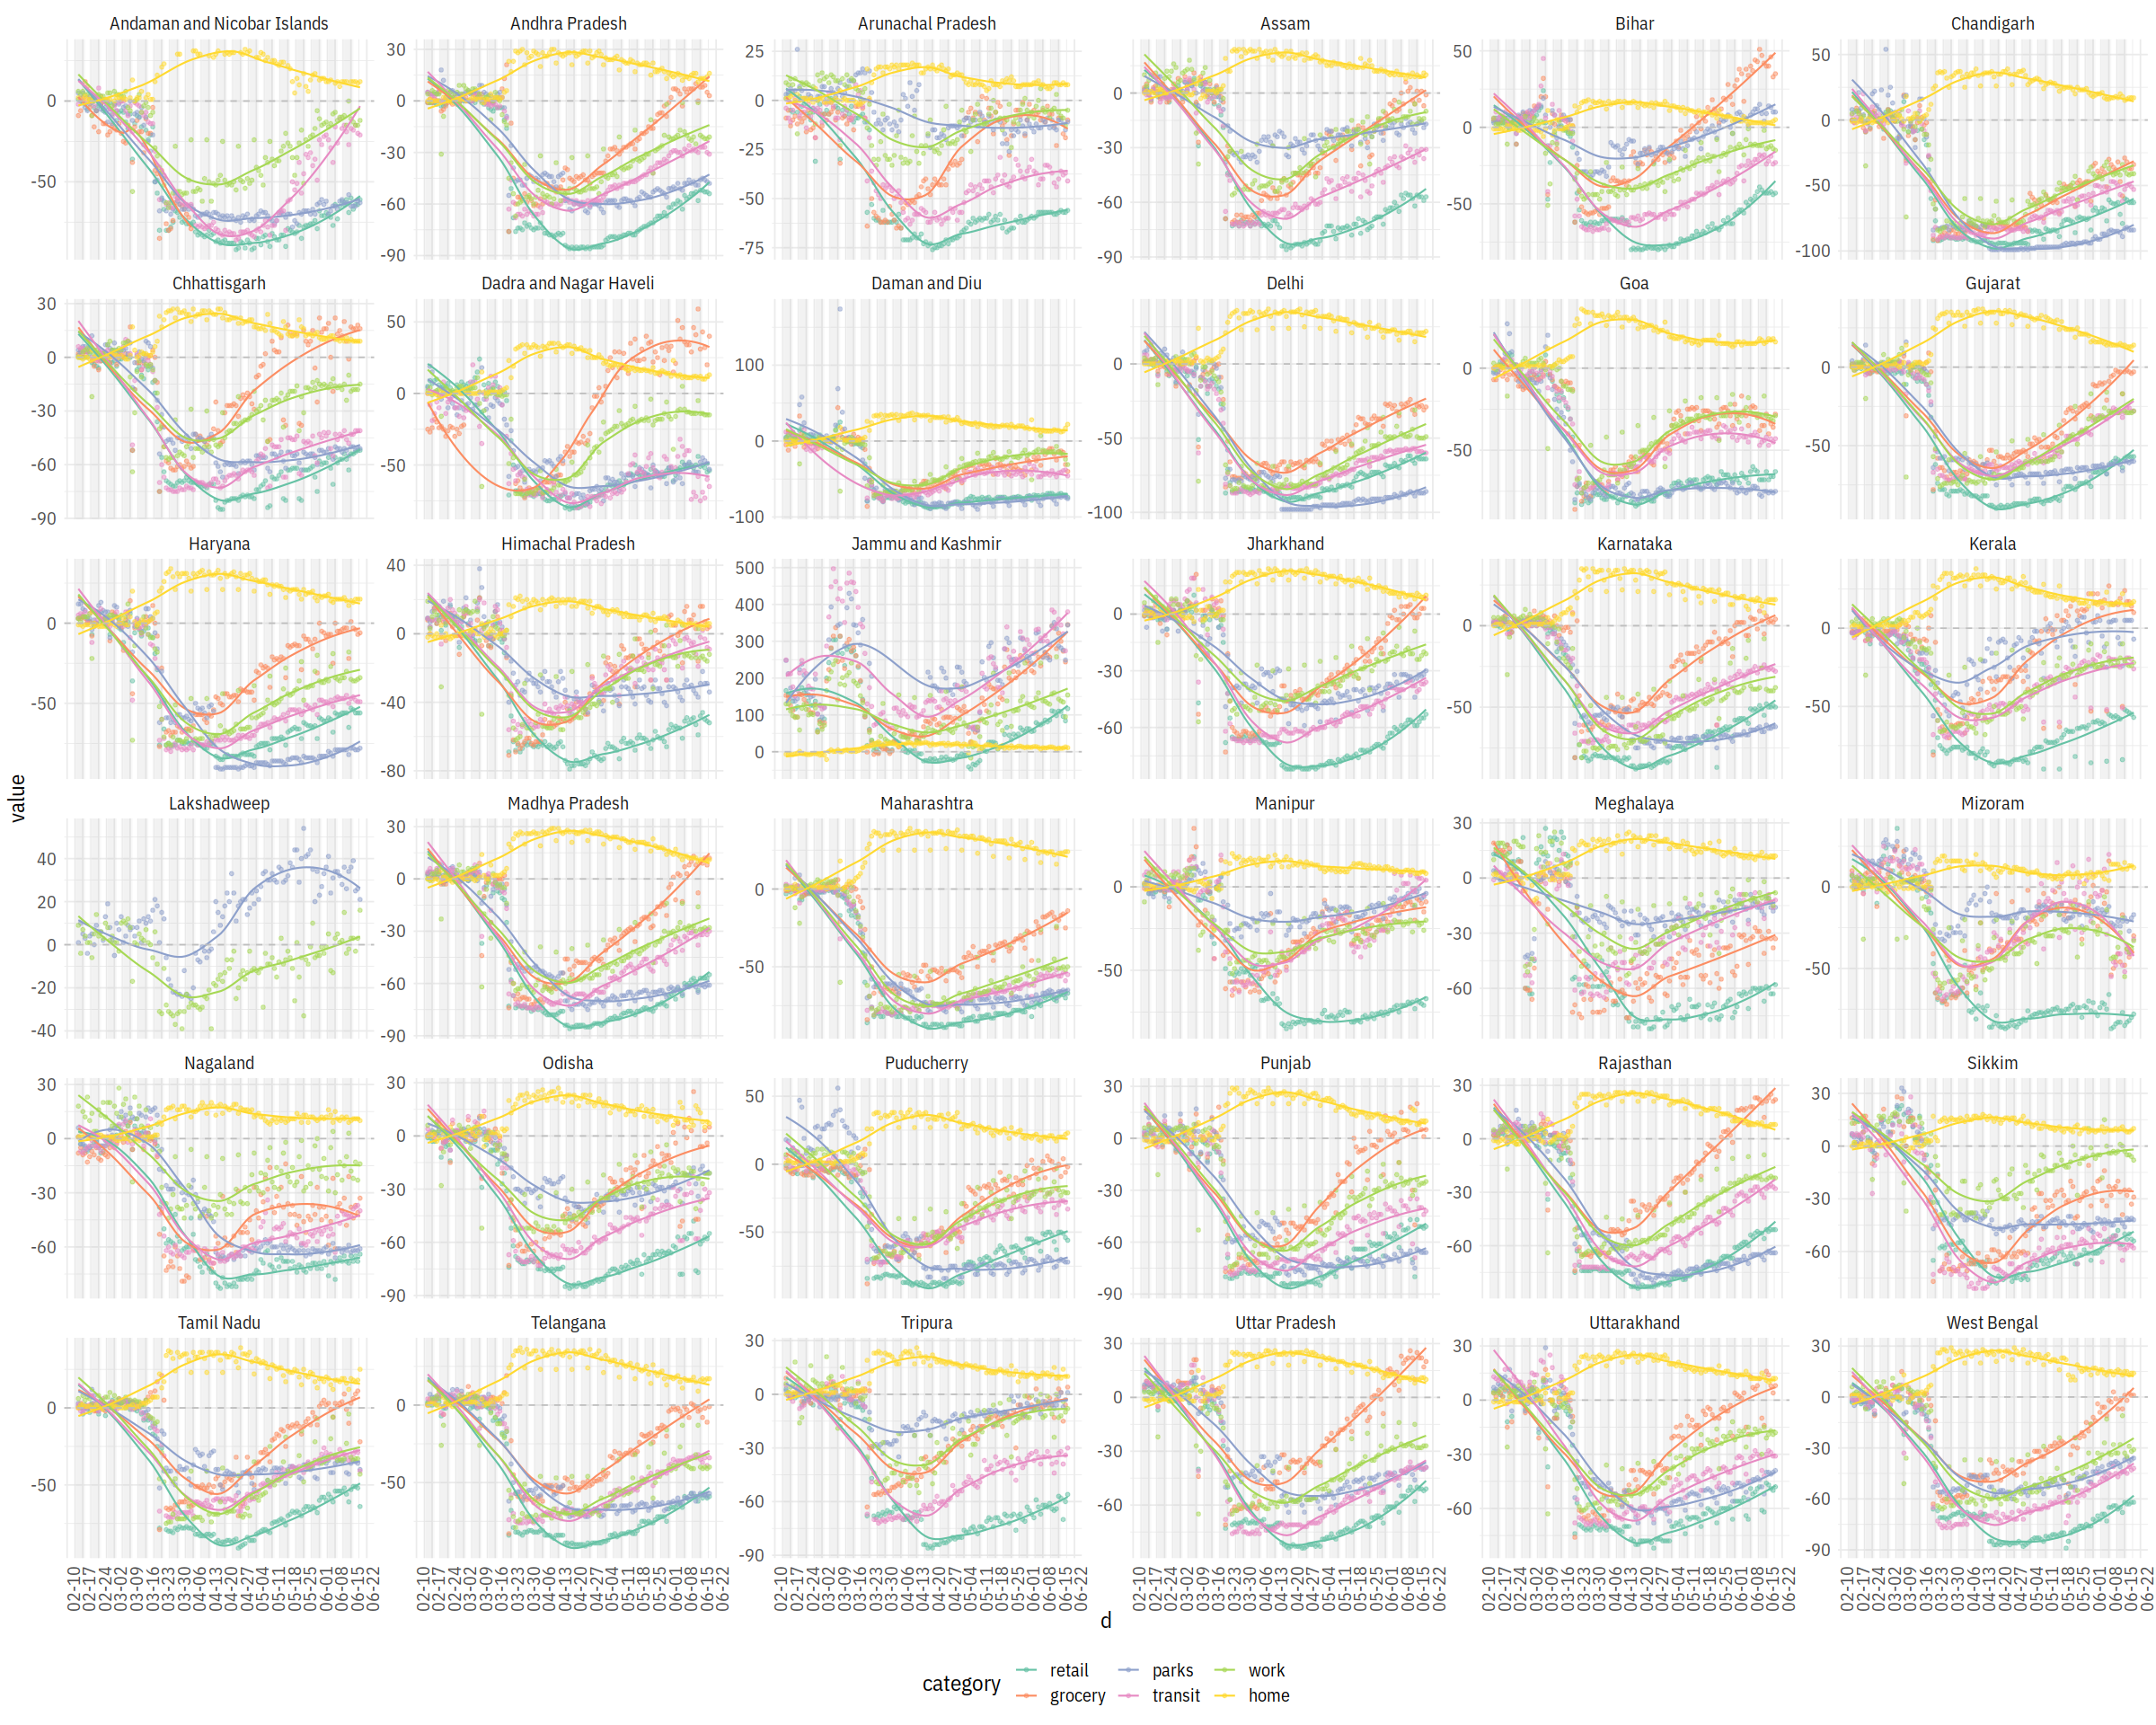

In [17]:
ind = mobility_df[country_region =="India"]
ind_l = melter(ind, c("sub_region_1", "d", "weekend"))
ind_l = ind_l[sub_region_1 != ""]
ind %>% head

(ind_disagg = subregion_faceted(ind_l, freescale = T))
ggsave("ind_mobility.jpg", ind_disagg, width = 30, height = 30)

Jammu and Kashmir up by 300%+ because the baseline period corresponds with a sever lockdown [for political reasons - abrogation of article 370 etc]. Baselines matter in DiD.

In [20]:
countries_w_subn = mobility_df[, .(sub = unique(sub_region_1)), by = country_region][sub != ""]
countries_w_subn[, unique(country_region)] %>% print

 [1] "United Arab Emirates" "Antigua and Barbuda"  "Angola"              
 [4] "Argentina"            "Austria"              "Australia"           
 [7] "Barbados"             "Belgium"              "Burkina Faso"        
[10] "Bulgaria"             "Benin"                "Bolivia"             
[13] "Brazil"               "The Bahamas"          "Belize"              
[16] "Canada"               "Switzerland"          "Côte d'Ivoire"       
[19] "Chile"                "Cameroon"             "Colombia"            
[22] "Cape Verde"           "Czechia"              "Germany"             
[25] "Denmark"              "Dominican Republic"   "Ecuador"             
[28] "Estonia"              "Egypt"                "Spain"               
[31] "Finland"              "France"               "Gabon"               
[34] "United Kingdom"       "Guatemala"            "Honduras"            
[37] "Croatia"              "Haiti"                "Hungary"             
[40] "Indonesia"            "Ireland" 

sub_region_1   d          weekend category value
1 Kajiado County 2020-02-15  TRUE   retail    -2  
2 Kajiado County 2020-04-07 FALSE   retail   -29  
3 Kajiado County 2020-04-08 FALSE   retail   -31  
4 Kajiado County 2020-04-09 FALSE   retail   -29  
5 Kajiado County 2020-04-10 FALSE   retail   -33  
6 Kajiado County 2020-04-13 FALSE   retail   -34

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10117 rows containing non-finite values (stat_smooth).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 18364”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 14.105”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 228.16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, d

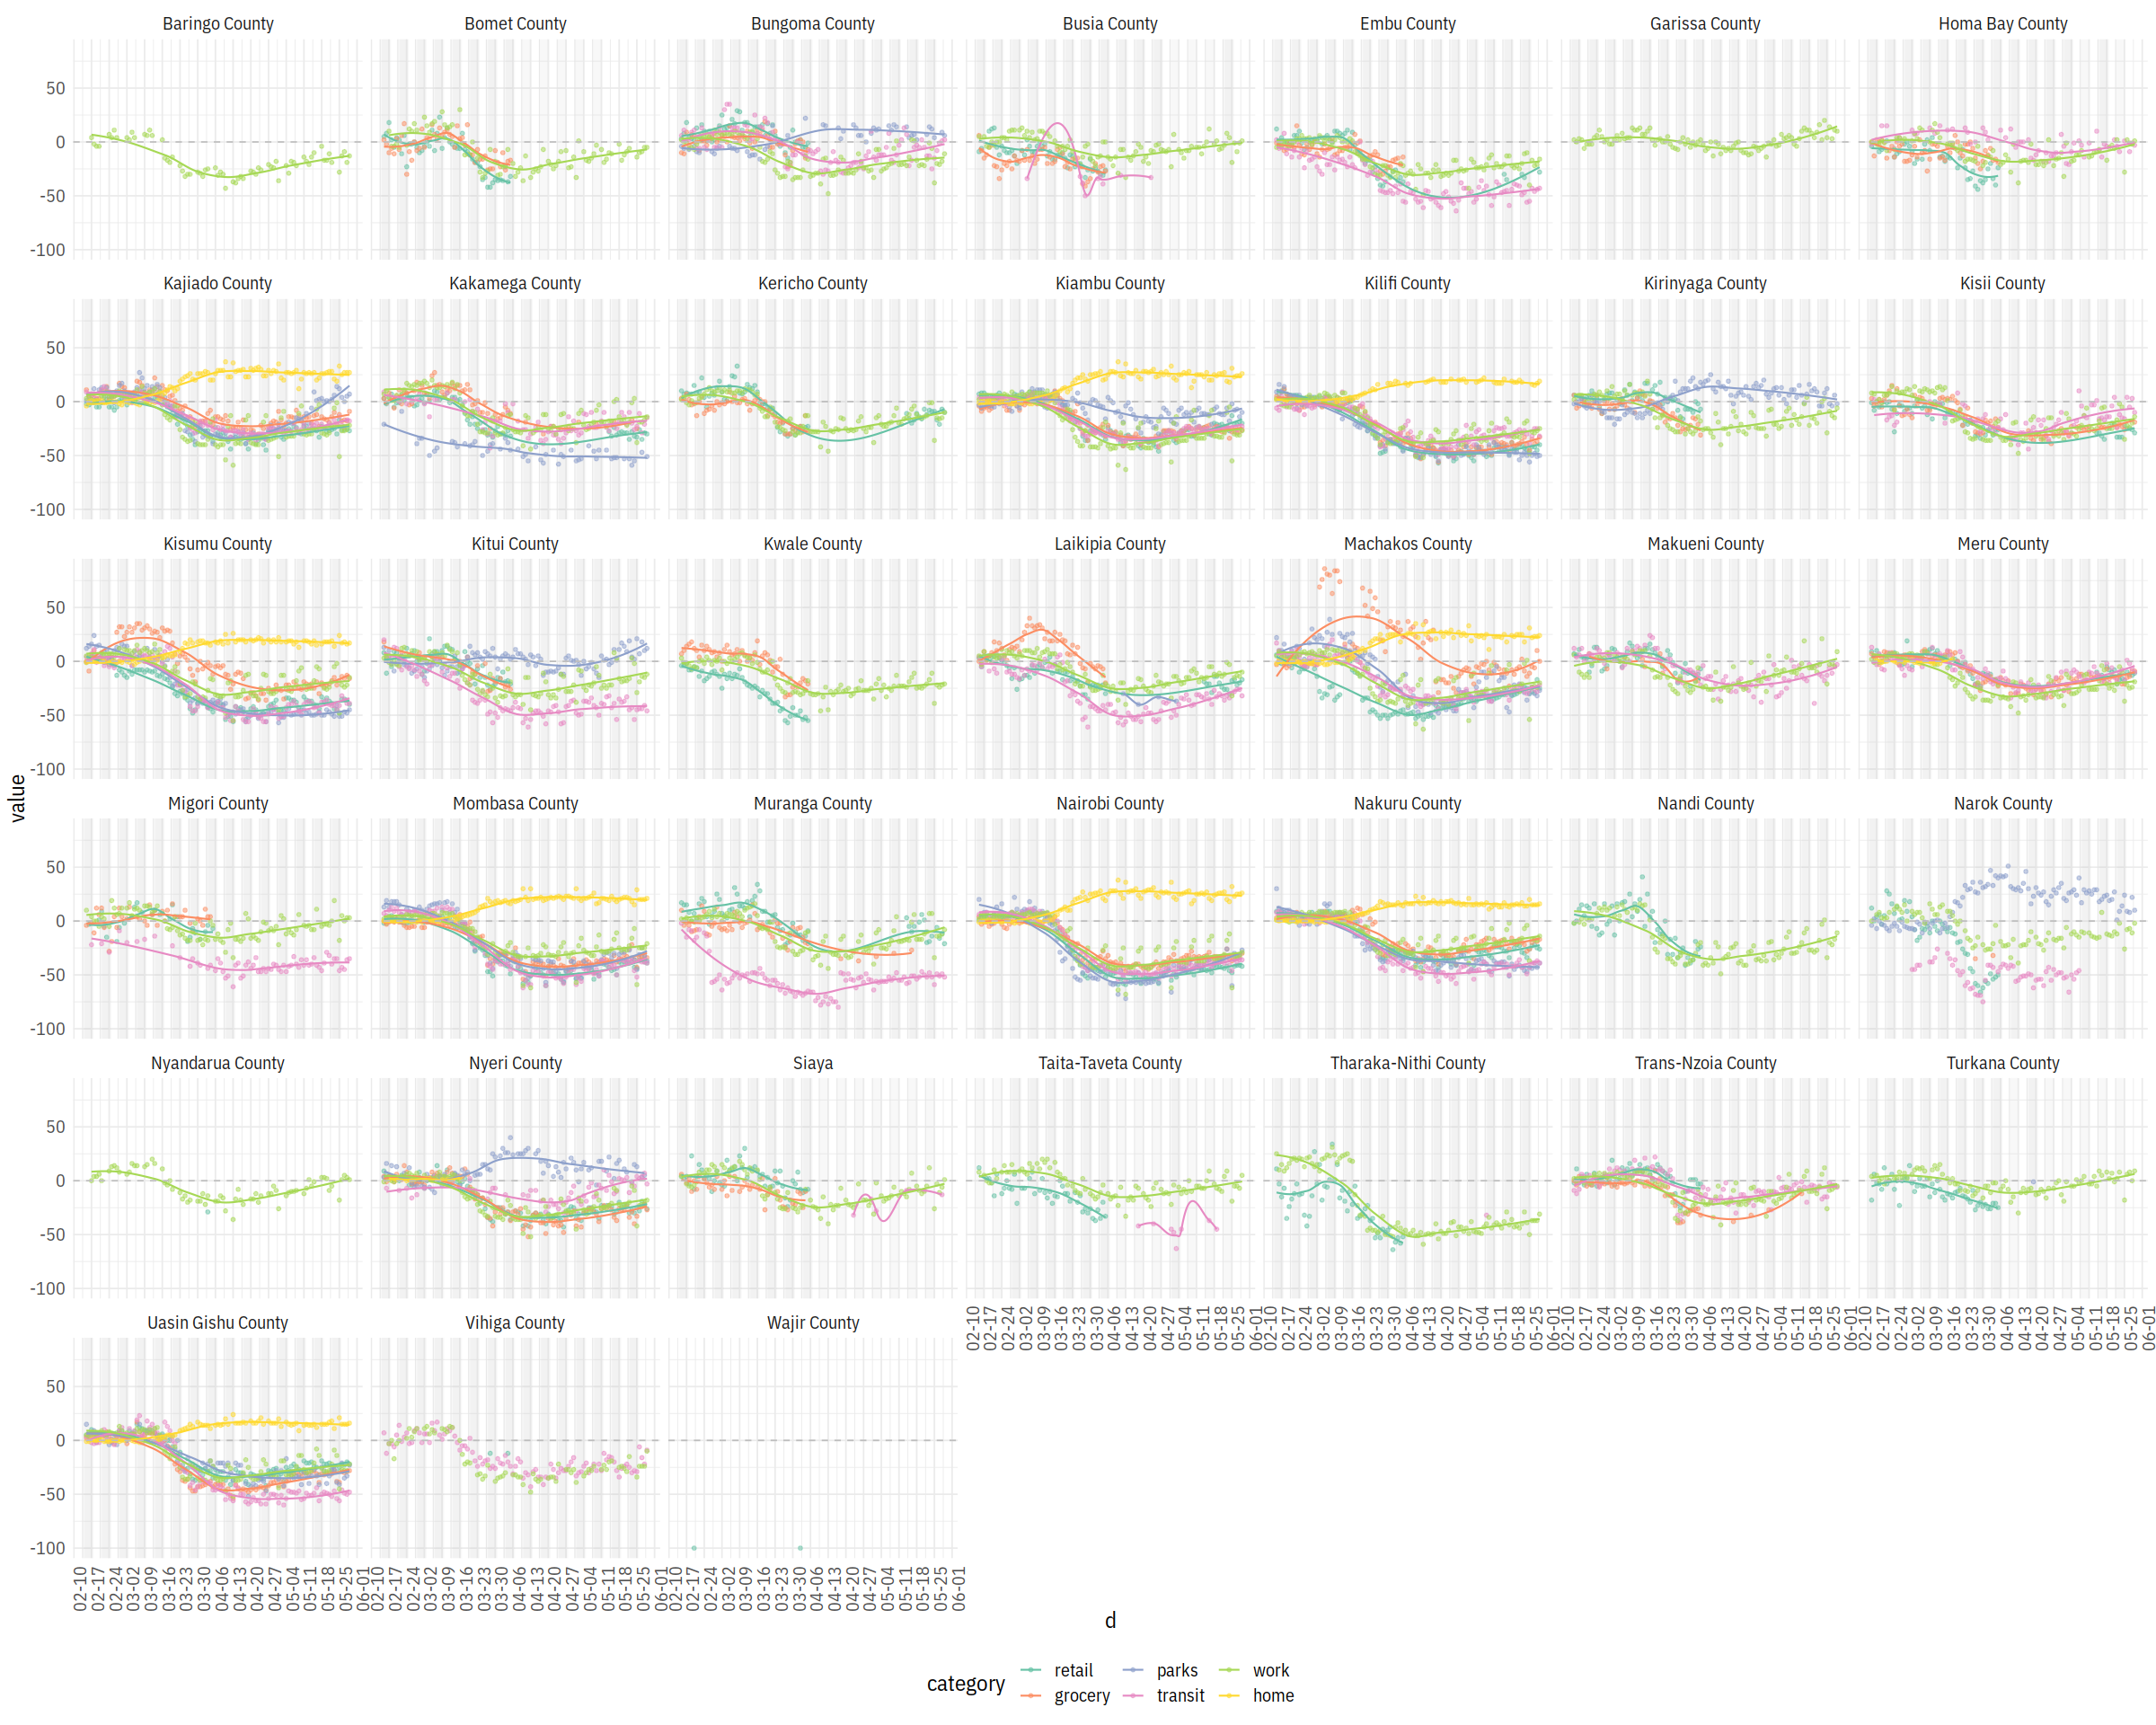

In [20]:
d = mobility_df[country_region =="Kenya"]
d_l= melter(d, c("sub_region_1", "d", "weekend")) %>% .[sub_region_1 != ""]
d_l %>% head

(ind_disagg = subregion_faceted(d_l))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”


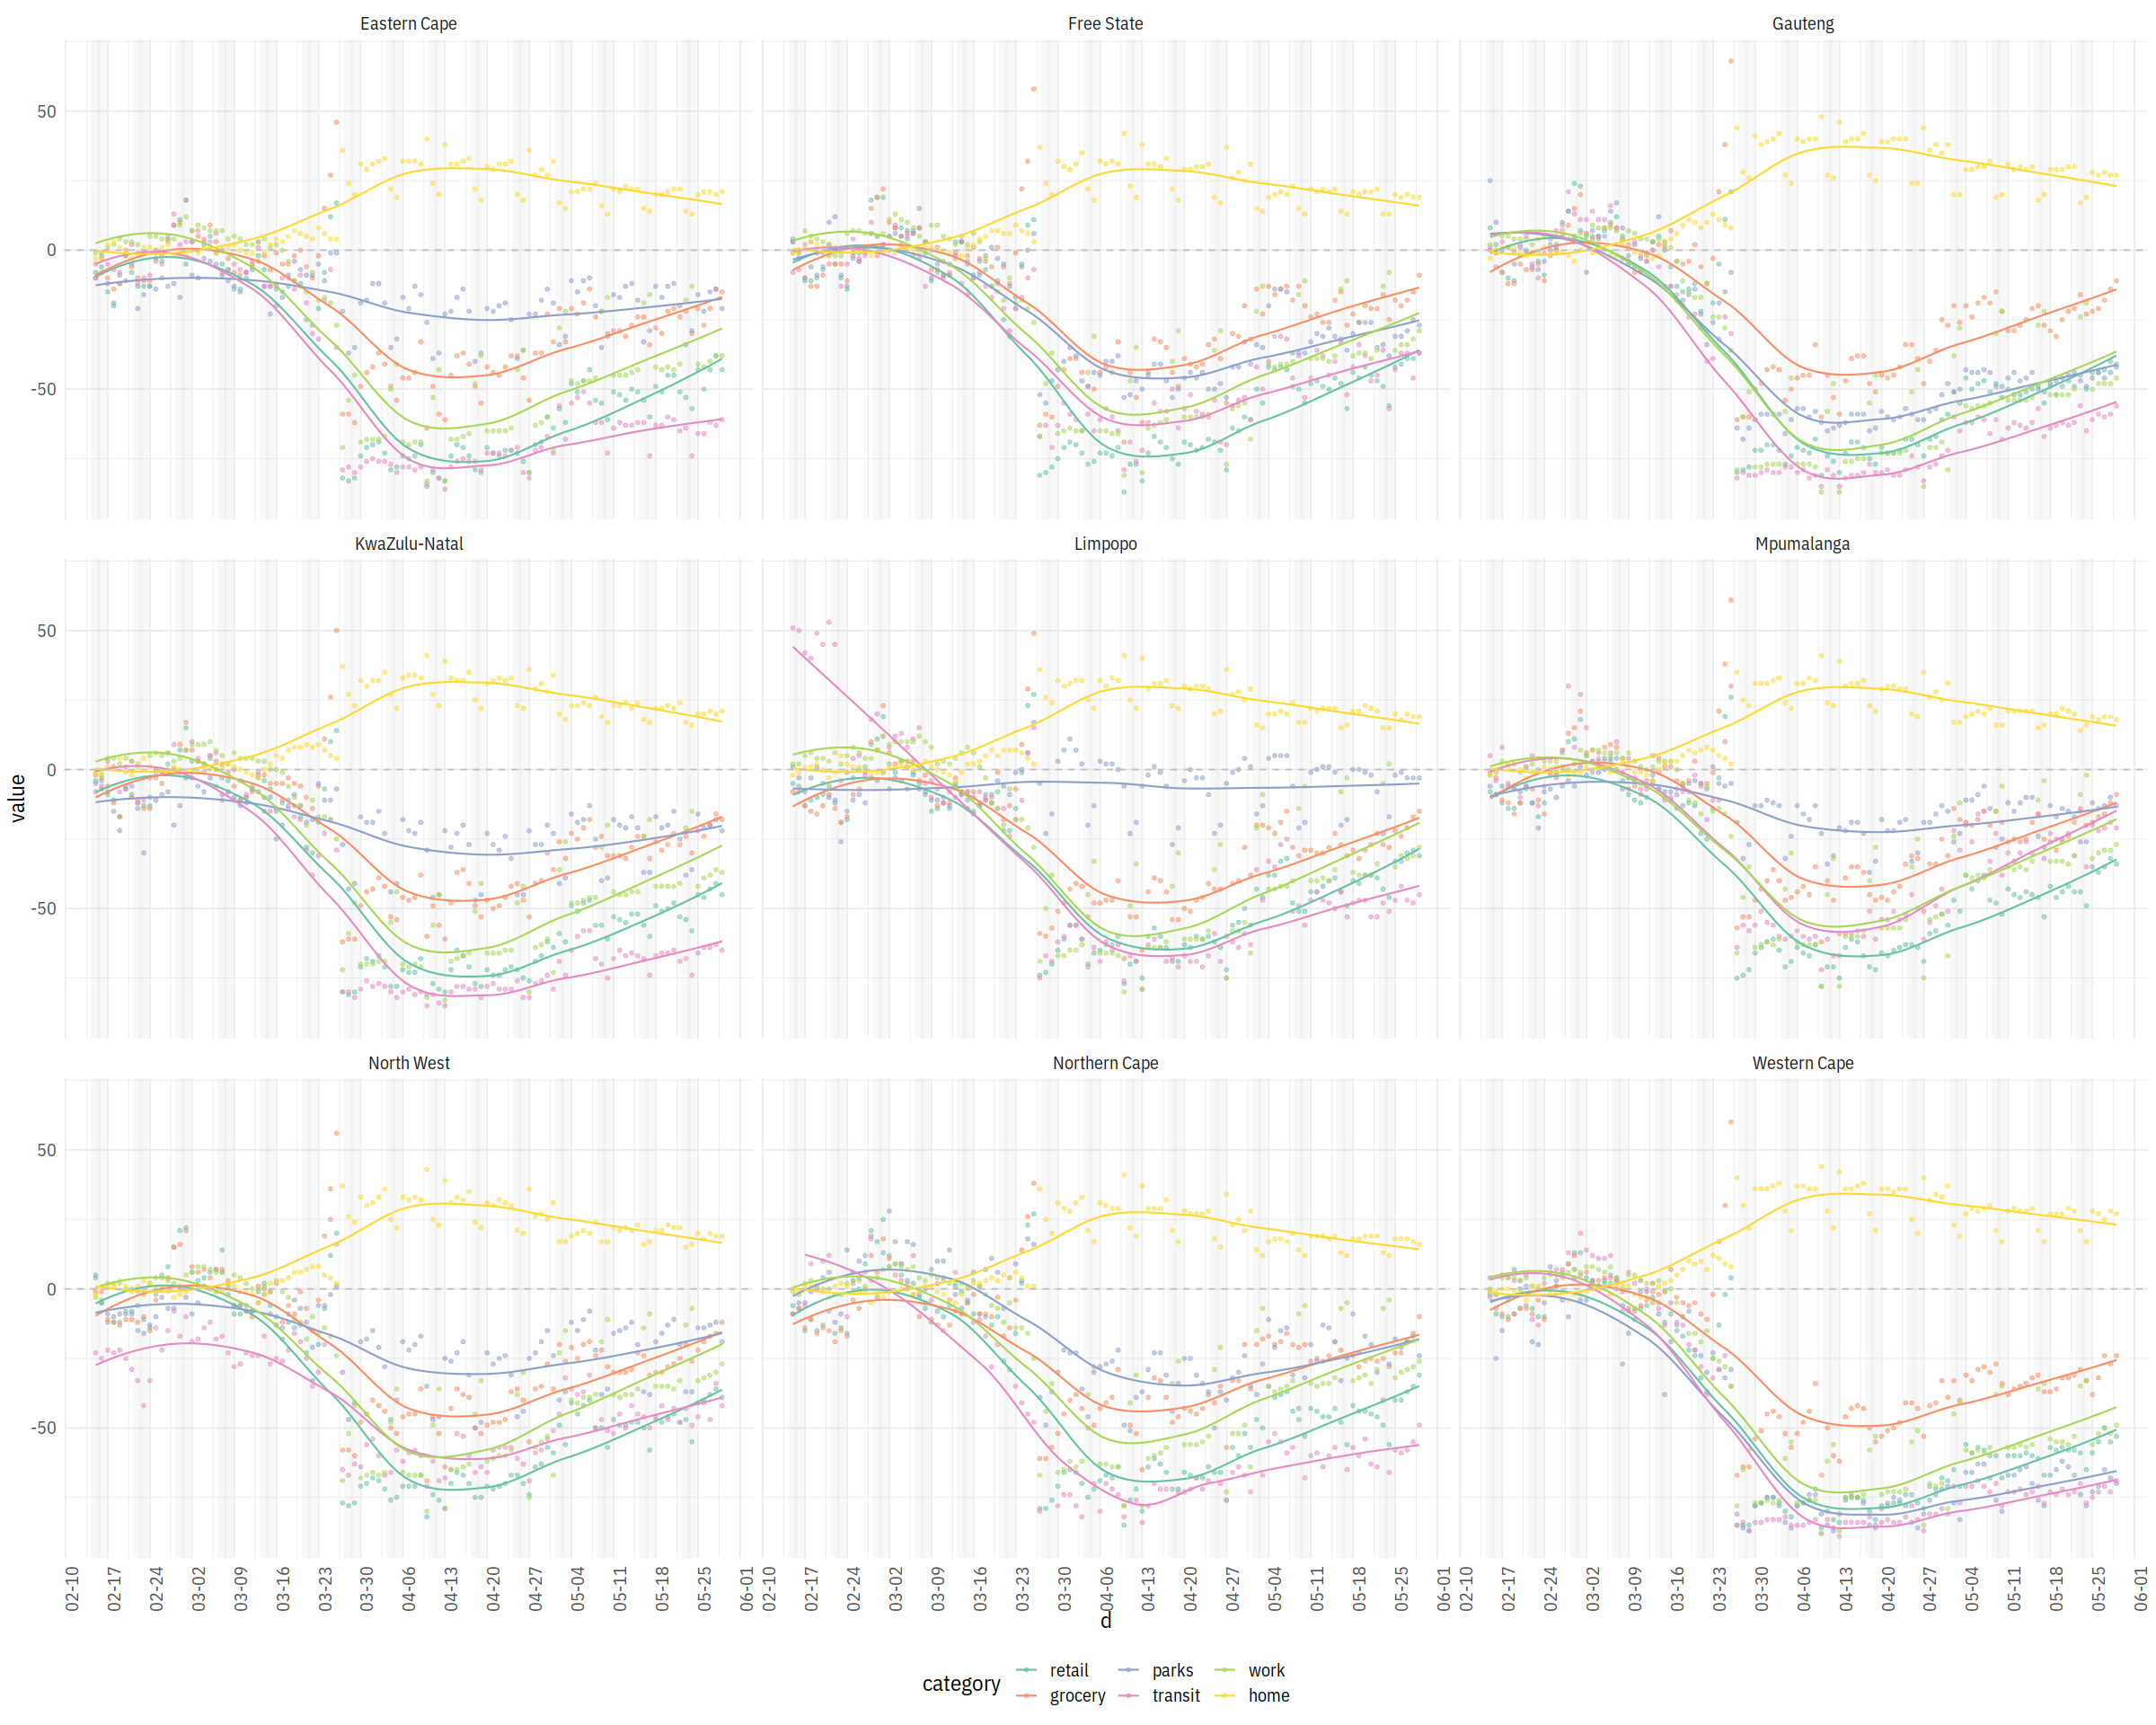

In [21]:
d = mobility_df[country_region =="South Africa"]
d_l= melter(d, c("sub_region_1", "d", "weekend")) %>% .[sub_region_1 != ""]
(ind_disagg = subregion_faceted(d_l))

# Oxford Govt Policy Tracker

In [18]:
options(repr.plot.width = 12, repr.plot.height=10)

In [20]:
projid <- Sys.getenv("GCE_DEFAULT_PROJECT_ID")
bq_auth(email = "lal.apoorva@gmail.com",
       path = "~/keys/sandbox.json")

In [21]:
bq_con <-  dbConnect(
    bigrquery::bigquery(),
    project = "bigquery-public-data",
    dataset = "covid19_govt_response",
    billing = projid
    )
bq_con
dbListTables(bq_con)

<BigQueryConnection>
  Dataset: bigquery-public-data.covid19_govt_response
  Billing: spatial-acumen-244921

[1] "oxford_policy_tracker"

In [22]:
mob <- tbl(bq_con, "oxford_policy_tracker")
mob %>% glimpse

Rows: ??
Columns: 51
Database: BigQueryConnection
$ country_name                            <chr> "Qatar", "Qatar", "Qatar", "Q…
$ alpha_3_code                            <chr> "QAT", "QAT", "QAT", "QAT", "…
$ date                                    <date> 2020-06-15, 2020-06-16, 2020…
$ school_closing                          <chr> "3", "3", "3", "3", "3", "3",…
$ school_closing_flag                     <chr> "1", "1", "1", "1", "1", "1",…
$ school_closing_notes                    <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ workplace_closing                       <chr> "2", "2", "2", "2", "2", "2",…
$ workplace_closing_flag                  <chr> "1", "1", "1", "1", "1", "1",…
$ workplace_closing_notes                 <chr> NA, NA, NA, NA, NA, NA, NA, N…
$ cancel_public_events                    <chr> "2", "2", "2", "2", "2", "2",…
$ cancel_public_events_flag               <chr> "1", "1", "1", "1", "1", "1",…
$ cancel_public_events_notes              <chr> "According to Reuters \"Qatar…
$ 

In [23]:
tic()
mob %>% collect() ->
    policies
toc()

8.514 sec elapsed


In [24]:
policies %<>% setDT

fwrite(policies, "data/ox_policy_tracker.csv")
dbDisconnect(bq_con)

### Viz

In [25]:
policies = fread("data/ox_policy_tracker.csv")
policies[, date := lubridate::ymd(date)]
policies %>% glimpse

Rows: 31,150
Columns: 51
$ country_name                            <chr> "Qatar", "Qatar", "Qatar", "Q…
$ alpha_3_code                            <chr> "QAT", "QAT", "QAT", "QAT", "…
$ date                                    <date> 2020-06-15, 2020-06-16, 2020…
$ school_closing                          <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, NA…
$ school_closing_flag                     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, NA…
$ school_closing_notes                    <chr> "", "", "", "", "", "", "", "…
$ workplace_closing                       <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, NA…
$ workplace_closing_flag                  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, NA…
$ workplace_closing_notes                 <chr> "", "", "", "", "", "", "", "…
$ cancel_public_events                    <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, NA…
$ cancel_public_events_flag               <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, NA…
$ cancel_public_events_notes              <chr> "According to Reuters \"\"Qat…
$ restrictions_on_gathering

In [26]:
policies[, .N, by = .(country_name, alpha_3_code)][order(country_name)]

country_name           alpha_3_code N  
1   Afghanistan            AFG          175
2   Albania                ALB          175
3   Algeria                DZA          175
4   Andorra                AND          175
5   Angola                 AGO          175
6   Argentina              ARG          175
7   Aruba                  ABW          175
8   Australia              AUS          175
9   Austria                AUT          175
10  Azerbaijan             AZE          175
11  Bahrain                BHR          175
12  Bangladesh             BGD          175
13  Barbados               BRB          175
14  Belarus                BLR          175
15  Belgium                BEL          175
16  Belize                 BLZ          175
17  Benin                  BEN          175
18  Bermuda                BMU          175
19  Bhutan                 BTN          175
20  Bolivia                BOL          175
21  Bosnia and Herzegovina BIH          175
22  Botswana               BWA          175
23  Brazil                 BRA          175
24  Brunei                 BRN          175
25  Bulgaria               BGR          175
26  Burkina Faso           BFA          175
27  Burundi                BDI          175
28  Cambodia               KHM          175
29  Cameroon               CMR          175
30  Canada                 CAN          175
⋮   ⋮                      ⋮            ⋮  
149 Spain                  ESP          175
150 Sri Lanka              LKA          175
151 Sudan                  SDN          175
152 Suriname               SUR          175
153 Sweden                 SWE          175
154 Switzerland            CHE          175
155 Syria                  SYR          175
156 Taiwan                 TWN          175
157 Tajikistan             TJK          175
158 Tanzania               TZA          175
159 Thailand               THA          175
160 Timor-Leste            TLS          175
161 Togo                   TGO          175
162 Trinidad and Tobago    TTO          175
163 Tunisia                TUN          175
164 Turkey                 TUR          175
165 Turkmenistan           TKM          175
166 Uganda                 UGA          175
167 Ukraine                UKR          175
168 United Arab Emirates   ARE          175
169 United Kingdom         GBR          175
170 United States          USA          175
171 Uruguay                URY          175
172 Uzbekistan             UZB          175
173 Vanuatu                VUT          175
174 Venezuela              VEN          175
175 Vietnam                VNM          175
176 Yemen                  YEM          175
177 Zambia                 ZMB          175
178 Zimbabwe               ZWE          175

In [27]:
sa = policies[alpha_3_code %in% c("IND", "NPL", "PAK", "BGD", "LKA", "AFG")]

tsplot = function(df){
    p = ggplot(df, aes(x = date, y = stringency_index, group = alpha_3_code, colour = alpha_3_code)) +
    geom_point() + geom_line() + scale_colour_brewer(palette = "Set2")
    return(p)
}

Warning message:
“Removed 1 rows containing missing values (geom_point).”


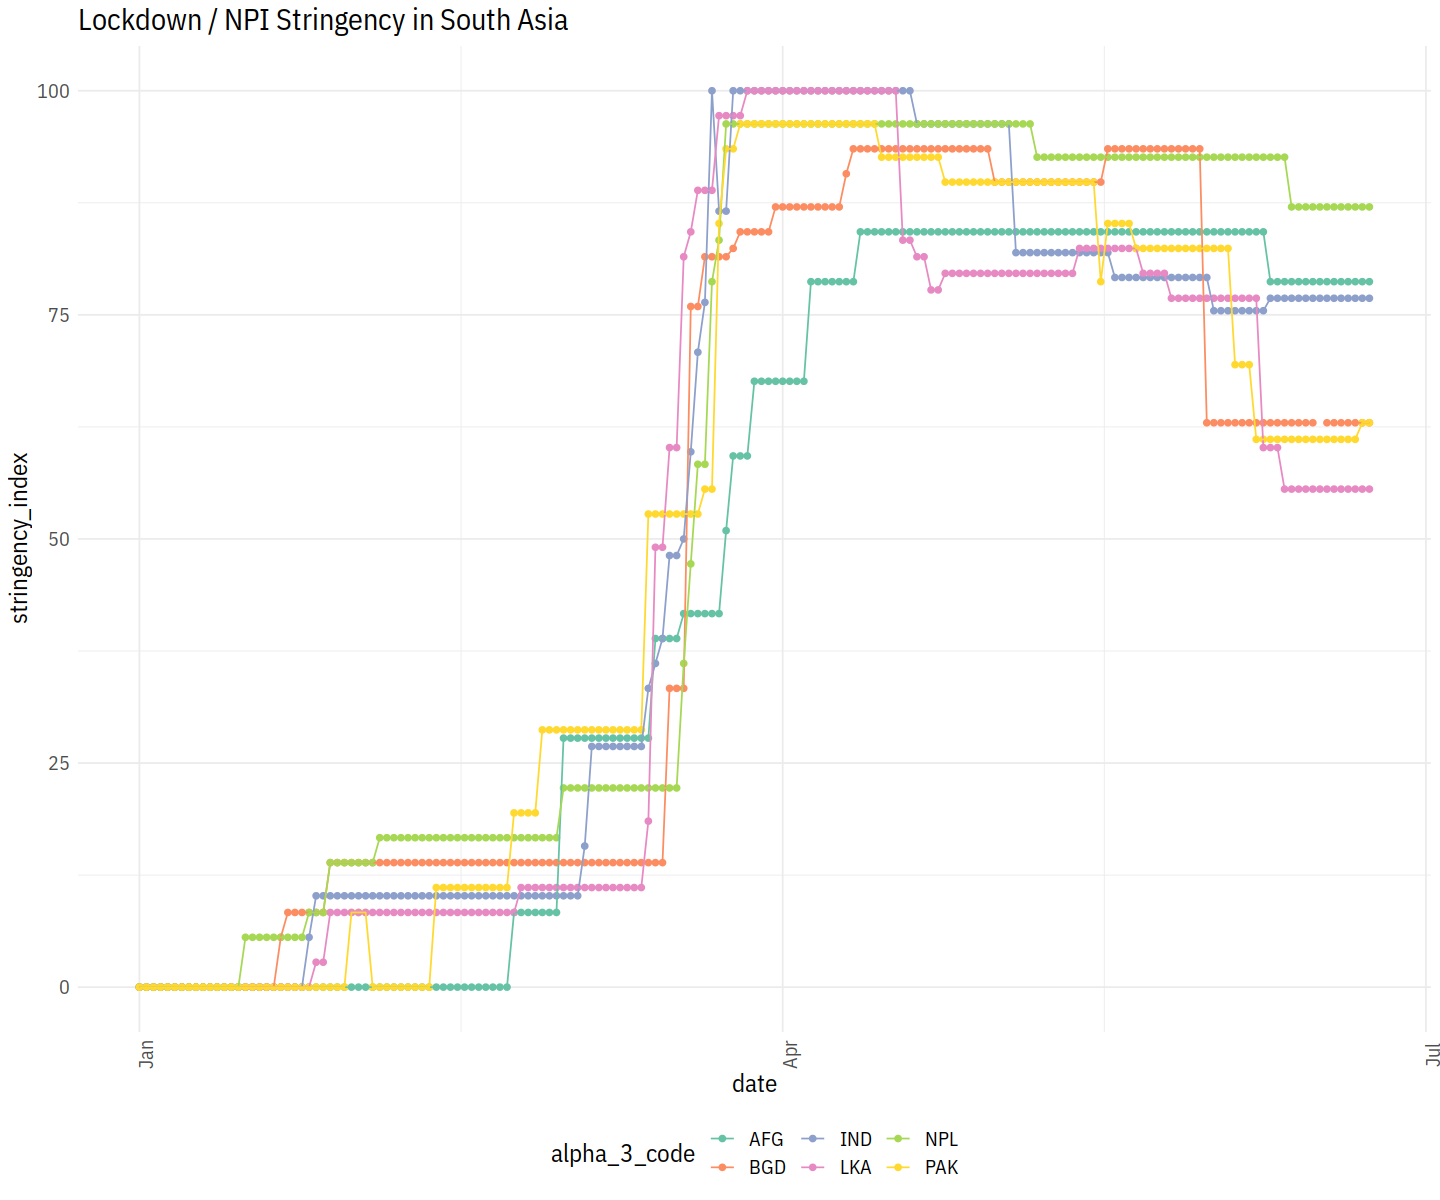

In [29]:
tsplot(sa) + ggtitle("Lockdown / NPI Stringency in South Asia")